In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data.csv')
df['absolute_swing_angle'] = abs(df['swing_angle'])
df['absolute_deviation'] = abs(df['deviation'])

# Repeating Feature engineering and model training, for the best model. I have documented my thought process in the model training and exploration notebook

In [3]:
def determine_bowling_type(row):
    if row['bowling_type'] == 'spin':
        if row['bowling_hand'] == 'right' and row['deviation'] > 0:
            return 'Right Arm Leg Spin'
        elif row['bowling_hand'] == 'left' and row['deviation'] < 0:
            return 'Left Arm Off Spin'
    elif row['bowling_type'] == 'pace':
        if row['bowling_hand'] == 'right':
            if row['swing_angle'] < 0:
                return 'Right Arm In Swing'
            else:
                return 'Right Arm Out Swing'
        elif row['bowling_hand'] == 'left':
            if row['swing_angle'] < 0:
                return 'Left Arm In Swing'
            else:
                return 'Left Arm Out Swing'
    return 'Unknown'

# Apply the function to the DataFrame
df['bowling_type_indicator'] = df.apply(determine_bowling_type, axis=1)

In [4]:
df['handedness_interaction'] = ((df['bowling_hand'] == 'right') & (df['batting_hand'] == 'left')
) | ((df['bowling_hand'] == 'left') & (df['batting_hand'] == 'right'))

df['handedness_interaction'] = df['handedness_interaction'].astype(int)

In [5]:
def bowling_type_position(row):
    if row['bowling_hand'] == 'right':
        if row['release_position_y'] < 0:
            return 'over_the_wicket'
        else:
            return 'around_the_wicket'
    elif row['bowling_hand'] == 'left':
        if row['release_position_y'] > 0:
            return 'over_the_wicket'
        else:
            return 'around_the_wicket'
    return 'unknown'

# Apply the function to create the feature
df['bowling_type_position'] = df.apply(bowling_type_position, axis=1)

In [6]:
def classify_length(row):
    if pd.isna(row['bounce_position_x']) or row['bounce_position_x'] > 19:
        if row['release_position_z'] >= 1.8:  
            return 'beamer'
        return 'full_toss'
    elif row['bounce_position_x'] <= 2:
        return 'yorker'
    elif row['bounce_position_x'] <= 4.5:
        return 'full'
    elif row['bounce_position_x'] <= 7:
        return 'good_length'
    else:
        return 'short_pitched'

df['delivery length'] = df.apply(classify_length, axis=1)

In [7]:
def classify_line(row):
    y_pos = row['stumps_position_y']  # Use the final position near stumps
    batter_hand = row['batting_hand']  # Batter handedness

    if -0.2 <= y_pos <= 0.2:  # Close to middle stump
        return 'straight'
    
    if batter_hand == 'right':  
        return 'wide_off_side' if y_pos < -0.2 else 'wide_leg_side'
    else:  # Left-handed batter
        return 'wide_leg_side' if y_pos < -0.2 else 'wide_off_side'

df['delivery_line'] = df.apply(classify_line, axis=1)

In [8]:
target = 'runs'

# Split into train & test (stratify if classification, otherwise just shuffle)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [9]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
continuous_cols = df.select_dtypes(include=['number']).columns.tolist()

In [10]:
agg_dfs = []  # Store aggregated DataFrames

# Loop through each categorical column and compute aggregates for all continuous variables
for cat_col in categorical_cols:
    agg_df = train_df.groupby(cat_col)[continuous_cols].agg(['mean', 'std']).reset_index()

    # Rename columns using the format categorical_metric_continuous
    agg_df.columns = [f"{cat_col}_{stat}_{col}" if stat else col for col, stat in agg_df.columns]

    # Merge back with train & test data
    train_df = train_df.merge(agg_df, on=cat_col, how='left')
    test_df = test_df.merge(agg_df, on=cat_col, how='left')  # Apply train mappings

    agg_dfs.append(agg_df)  # Store for reference

In [11]:
run_weights = {0:0.8,1:0.8,2:1,3:0.5,4:2,6:2,5:0.5}
train_df['weights'] = train_df['runs'].map(run_weights)

In [12]:
y_train = train_df.pop('runs')
X_train = train_df.copy()
y_test = test_df.pop('runs')
X_test = test_df.copy()
weights = X_train.pop('weights')
X_train.drop('wicket',axis=1,inplace=True)
X_test.drop('wicket',axis=1,inplace=True)

In [13]:
X_train.drop(categorical_cols,axis=1,inplace=True)
X_test.drop(categorical_cols,axis=1,inplace=True)

In [14]:
model = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=400,
    learning_rate=0.05,
    objective='multi:softprob',  # Multi-class classification
    random_state=42,
    num_class=7 # Number of categories/classes (adjust as needed)
)

# Train model
model.fit(X_train, y_train,sample_weight=weights)

# Predict and evaluate
y_pred = model.predict(X_test)

In [15]:
accuracy_score(y_test, y_pred)

0.4327655759748992

In [16]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [17]:
results_df['Actual'].value_counts()

Actual
1    15924
0    14848
4     4433
2     2709
6     2082
3      152
5       10
Name: count, dtype: int64

In [18]:
results_df['Predicted'].value_counts()

Predicted
1    19576
0    13838
4     6553
6      183
2        8
Name: count, dtype: int64

In [19]:
y_pred_prob = model.predict_proba(X_test)

# Create a DataFrame with the probabilities
probabilities_df = pd.DataFrame(y_pred_prob, columns=[f'Class_{i}' for i in range(7)])

# Add the actual labels to the DataFrame
probabilities_df['Actual'] = y_test.values

In [20]:
log_loss(y_test, y_pred_prob)

1.3454514259032626

In [21]:
roc_auc_score(y_test, y_pred_prob, multi_class="ovr")

0.6122065178127176

In [22]:
target_variance = np.var(y_test)
print("Variance of Target (Runs):", target_variance)

Variance of Target (Runs): 2.6579355760111505


In [23]:
predicted_variance = np.var(y_pred)
print("Variance of Model Predictions:", predicted_variance)

Variance of Model Predictions: 1.8991343002848302


In [24]:
variance_ratio = predicted_variance / target_variance
print("Variance Ratio:", variance_ratio)

Variance Ratio: 0.7145147976592128


In [25]:
import shap

In [26]:
explainer = shap.Explainer(model, X_train)

In [27]:
sample_X_test = X_test.sample(3000)

In [28]:
shap_values = explainer(sample_X_test)

100%|===================| 20995/21000 [60:34<00:00]        

In [44]:
shap_values_2d = shap_values.values[:, :, 6]

In [45]:
feature_names = X_train.columns

# Post model analysis

# Lets first analyse what features impact 6s

# Shap summary plot for probability of a delivery going for 6

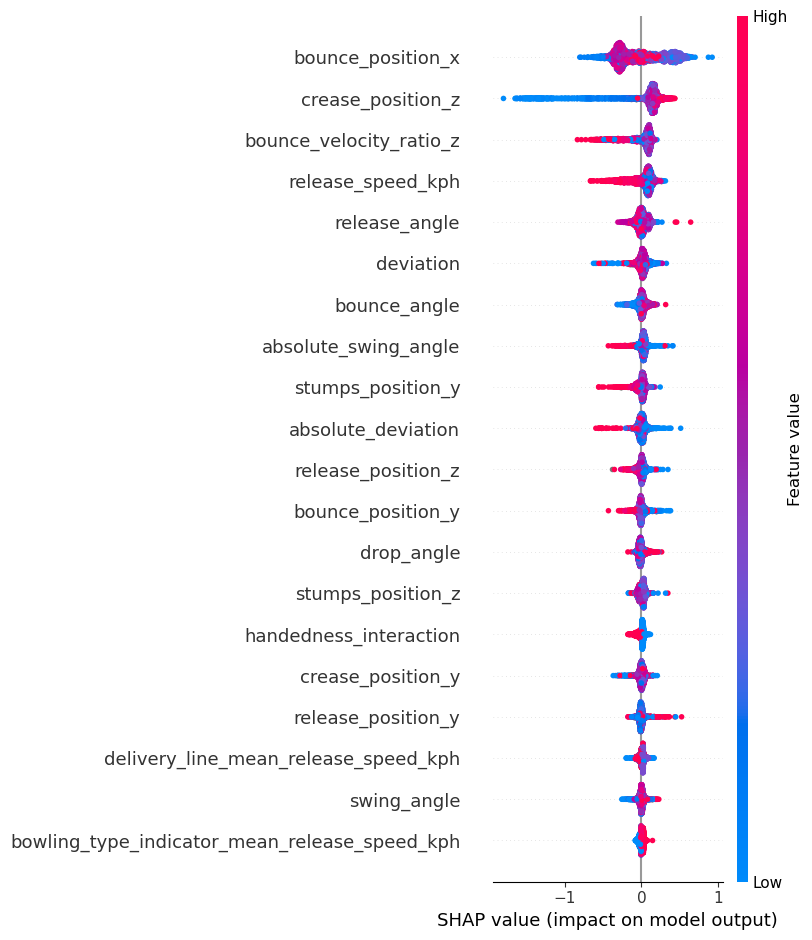

In [47]:
shap.summary_plot(shap_values_2d, sample_X_test, feature_names=feature_names)

# 1. Bounce Position - Sometimes, very low bounce position x (distance of pitch of the ball from the bowling end) increases the probability of being hit for six, but sometimes (maybe in case of yorkers), a lower bounce position is a good thing. Shapely values close to 0 (maybe representing good length deliveries, decrease the probabilty of being hit for 6)
So 
# 2. Crease position z - a lower height of the ball at crease level, significantly decreases the chances of being hit for 6. A slightly higher delivery at the crease is more likely to be hit for 6

# 3. bounce velocity ratio - A higher bounce velocity ratio singificantly reduces the chances of being hit for 6. This is probably more to do with the behviour of the pitch. If the conditions are such that the speed decreases significantly after it pitches, then its easier to hit a ball for 6.

# 4. Other features such as abolsute swing angle and absolute deviation also impact the probability of being hit for 6 (lower the value, higher the probability)

# Now, lets look at shapely values for dot balls

In [33]:
shap_values_2d = shap_values.values[:, :, 0]

#  Shap summary plot for probability of a delivery being a dot

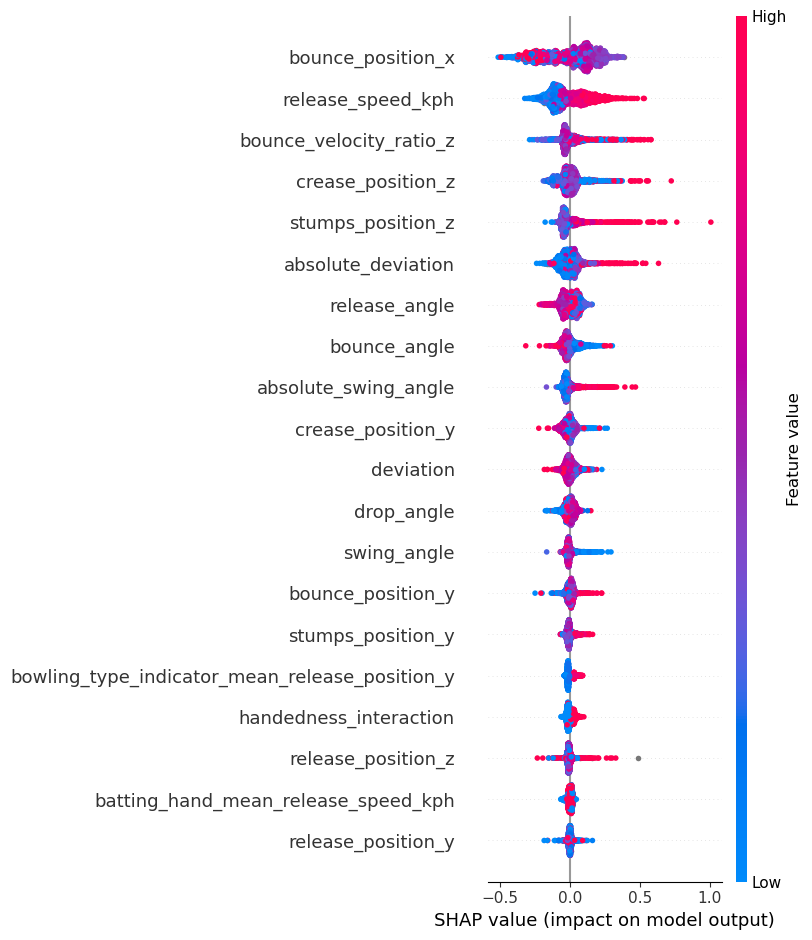

In [34]:
shap.summary_plot(shap_values_2d, sample_X_test, feature_names=feature_names)

# 1. Higher release speeds increases the chances of a delivery being a dot ball.
# 2. Higher the bounce velocity ratio, the better
# 3. As it can be seen the plot is almost a proper reverse of the 6s plot

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

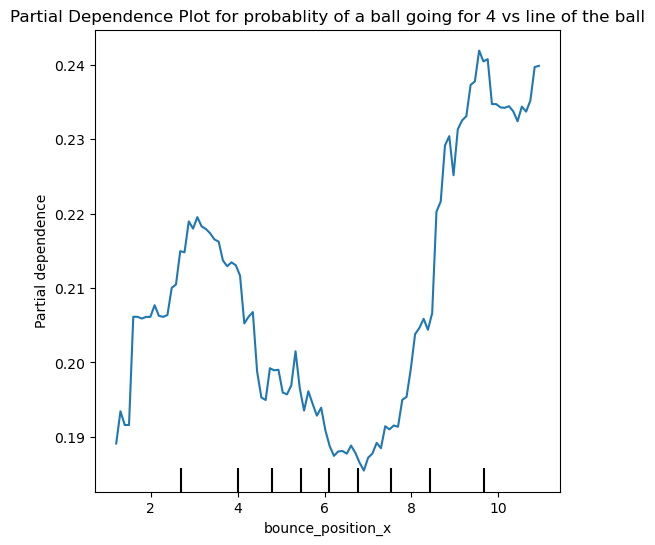

In [49]:
features = ["bounce_position_x"]  # Change this to relevant feature indices/names
pdp_results = partial_dependence(
    model, X_train.sample(10000), features, kind="average"
)

# Plot the PDP
fig, ax = plt.subplots(figsize=(6, 6))
PartialDependenceDisplay.from_estimator(
    model, X_train.sample(10000), features, kind="average", target=4, ax=ax
)
plt.title("Partial Dependence Plot for probablity of a ball going for 4 vs line of the ball")
plt.show()

# A delivery between the 6 to 7 meter mark has the lowest probability of being hit for a boundary

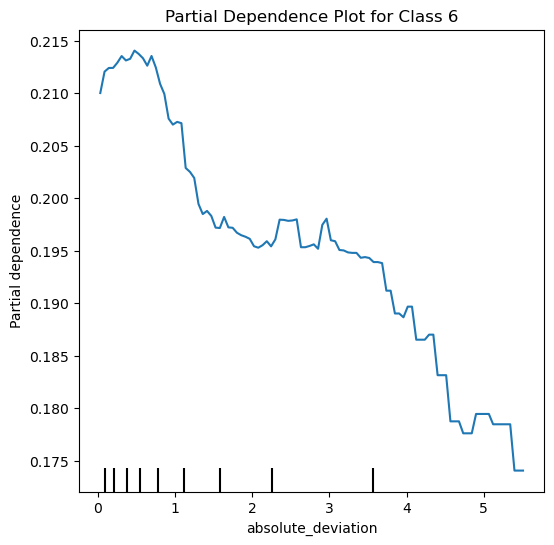

In [42]:
features = ["absolute_deviation"]  # Change this to relevant feature indices/names
pdp_results = partial_dependence(
    model, X_train[:10000], features, kind="average"
)

# Plot the PDP
fig, ax = plt.subplots(figsize=(6, 6))
PartialDependenceDisplay.from_estimator(
    model, X_train[:10000], features, kind="average", target=4, ax=ax
)
plt.title("Partial Dependence Plot for probablity of a ball going for 4 vs deviation (spin/swing)")
plt.show()

# Higher the deviation, lower the probability of being hit for a boundary

# Wanted to explore 2d pdps , but it took forever to run


KeyboardInterrupt



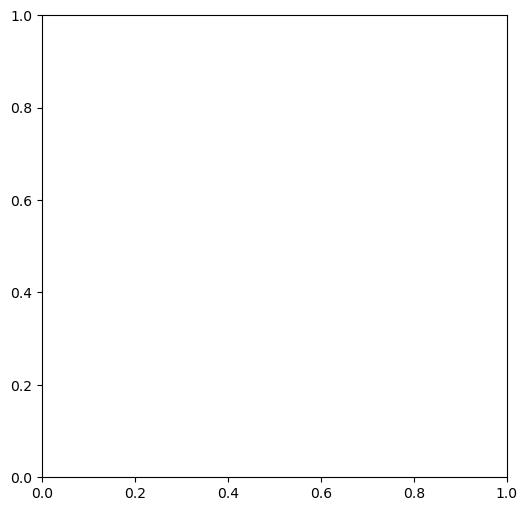

In [62]:
X_sample = X_train.sample(1000, random_state=42)

# Define 2D feature interaction
features = [("absolute_deviation", "release_speed_kph")]

# Create PDP plot (directly using `from_estimator`)
fig, ax = plt.subplots(figsize=(6, 6))
disp = PartialDependenceDisplay.from_estimator(
    model, X_sample, features, kind="average", target=4, ax=ax
)

# Set title and labels
plt.title("2D Partial Dependence Plot: Probability of 4 vs Deviation & Speed")
plt.xlabel("Absolute Deviation (Spin/Swing)")
plt.ylabel("Ball Speed")
plt.show()